In [1]:
import os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'TRUE'

from keras.preprocessing import image
from keras.applications import InceptionResNetV2
from keras.models import Sequential, load_model
from keras.layers import Dense, GlobalAveragePooling2D
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
import numpy as np

# Function to preprocess images
def preprocess_image(img_path, target_size=(224, 224)):
    img = image.load_img(img_path, target_size=target_size)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0  # Normalize pixel values to between 0 and 1
    return img_array


In [2]:
from google.colab import drive
import zipfile
import os

# Mount Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [27]:
# Paths
zip_file_path = '/content/drive/MyDrive/Emotions.zip'
extracted_folder_path = '/content/drive/MyDrive/Emotion/'

# Extract the 'archive' folder
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extracted_folder_path)

In [29]:
# Update data directories
extracted_folder_path = '/content/drive/MyDrive/Emotion/Emotions'

train_data_dir = os.path.join(extracted_folder_path, 'train')
test_data_dir = os.path.join(extracted_folder_path, 'test')


In [30]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Set up data generators
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Create generators
train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(224, 224),
    batch_size=128,
    class_mode='categorical'  # Specify the class mode
)

validation_generator = test_datagen.flow_from_directory(
    test_data_dir,
    target_size=(224, 224),
    batch_size=128,
    class_mode='categorical'  # Specify the class mode
)

# Get the class indices (mapping of class names to indices)
class_indices = train_generator.class_indices

# Reverse the mapping to get class names
class_names = list(class_indices.keys())

# Print or use class names as needed
print("Class names:", class_names)


Found 15351 images belonging to 3 classes.
Found 3838 images belonging to 3 classes.
Class names: ['happy', 'neutral', 'surprise']


Pre Trained Model

In [32]:
from keras.applications import VGG16

# Load the pre-trained VGG16 model
conv_base = VGG16(weights='imagenet',
                 include_top=False,
                 input_shape=(224, 224, 3))

# Get the number of layers
num_layers = len(conv_base.layers)
print("Number of layers in the VGG16 model:", num_layers)

# Freeze layers up to a certain point
for layer in conv_base.layers[:-4]:
    layer.trainable = False


Number of layers in the VGG16 model: 19


In [33]:
# Print the status of each layer
for i, layer in enumerate(conv_base.layers):
    print(f"Layer {i}: {layer.name} - Trainable: {layer.trainable}")

Layer 0: input_3 - Trainable: False
Layer 1: block1_conv1 - Trainable: False
Layer 2: block1_conv2 - Trainable: False
Layer 3: block1_pool - Trainable: False
Layer 4: block2_conv1 - Trainable: False
Layer 5: block2_conv2 - Trainable: False
Layer 6: block2_pool - Trainable: False
Layer 7: block3_conv1 - Trainable: False
Layer 8: block3_conv2 - Trainable: False
Layer 9: block3_conv3 - Trainable: False
Layer 10: block3_pool - Trainable: False
Layer 11: block4_conv1 - Trainable: False
Layer 12: block4_conv2 - Trainable: False
Layer 13: block4_conv3 - Trainable: False
Layer 14: block4_pool - Trainable: False
Layer 15: block5_conv1 - Trainable: True
Layer 16: block5_conv2 - Trainable: True
Layer 17: block5_conv3 - Trainable: True
Layer 18: block5_pool - Trainable: True


In [36]:
from keras import models
from keras import layers

model = models.Sequential()

model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(3, activation='softmax'))
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten_2 (Flatten)         (None, 25088)             0         
                                                                 
 dense_4 (Dense)             (None, 128)               3211392   
                                                                 
 dense_5 (Dense)             (None, 3)                 387       
                                                                 
Total params: 17926467 (68.38 MB)
Trainable params: 3211779 (12.25 MB)
Non-trainable params: 14714688 (56.13 MB)
_________________________________________________________________


In [37]:
from keras import losses, optimizers, metrics
from keras.callbacks import EarlyStopping

# Set the convolutional base to non-trainable
conv_base.trainable = False
print('This is the number of trainable weights before freezing the conv base:', len(model.trainable_weights))

# Compile the model
model.compile(
    optimizer=optimizers.Adam(learning_rate=0.001),
    loss=losses.categorical_crossentropy,
    metrics=[metrics.categorical_accuracy]
)

# Define EarlyStopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(
    train_generator,
    epochs=20,
    validation_data=validation_generator,
    callbacks=[early_stopping]
)


This is the number of trainable weights before freezing the conv base: 4
Epoch 1/20
120/120 [==============================] - 130s 1s/step - loss: 1.1332 - categorical_accuracy: 0.5986 - val_loss: 0.6221 - val_categorical_accuracy: 0.7493
Epoch 2/20
120/120 [==============================] - 85s 705ms/step - loss: 0.5569 - categorical_accuracy: 0.7796 - val_loss: 0.5522 - val_categorical_accuracy: 0.7791
Epoch 3/20
120/120 [==============================] - 81s 669ms/step - loss: 0.4816 - categorical_accuracy: 0.8138 - val_loss: 0.4999 - val_categorical_accuracy: 0.8038
Epoch 4/20
120/120 [==============================] - 81s 672ms/step - loss: 0.4402 - categorical_accuracy: 0.8273 - val_loss: 0.4883 - val_categorical_accuracy: 0.8007
Epoch 5/20
120/120 [==============================] - 82s 685ms/step - loss: 0.4092 - categorical_accuracy: 0.8422 - val_loss: 0.5300 - val_categorical_accuracy: 0.7811
Epoch 6/20
120/120 [==============================] - 86s 712ms/step - loss: 0.3699 

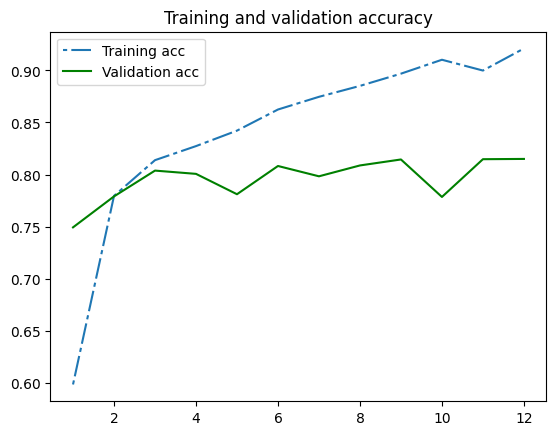

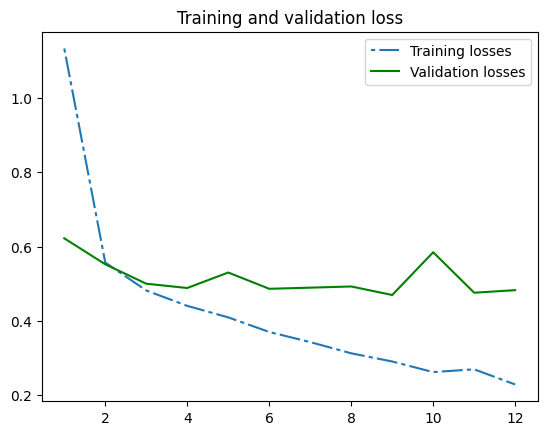

In [38]:
import matplotlib.pyplot as plt

acc = history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc)+1)

plt.plot(epochs, acc, dashes=[2, 2, 10, 2], label='Training acc')
plt.plot(epochs, val_acc, 'g', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()
plt.plot(epochs, loss, dashes=[2, 2, 10, 2], label='Training losses')
plt.plot(epochs, val_loss, 'g', label='Validation losses')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [44]:
model.save('/content/drive/MyDrive/Model/FacialEmotion2.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [42]:
from keras.models import load_model
emotion_model = load_model('/content/drive/MyDrive/Model/FacialEmotion2.h5')

In [43]:
emotion_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten_2 (Flatten)         (None, 25088)             0         
                                                                 
 dense_4 (Dense)             (None, 128)               3211392   
                                                                 
 dense_5 (Dense)             (None, 3)                 387       
                                                                 
Total params: 17926467 (68.38 MB)
Trainable params: 3211779 (12.25 MB)
Non-trainable params: 14714688 (56.13 MB)
_________________________________________________________________


Calculating Accuracy